# Homework 8 Solutions

Computational Physics Fall 2025 

# Problem 1: More Springs

We have a second order PDE that we want to solve numerically. The way we do it is by writing the time component of $u$ in modes, effectively converting it into a system of second order ODEs, one for each mode. Then we use finite differences to come up with a matrix equation to approximate the solution for each mode, and use the matrix to solve for the possible eigenvalues. Then putting everything together with some initial conditions we can solve.

Let's work out the matrix. Denoting the derivatives with indices we have that the equation is
$$
-\rho u_{tt} + pu_{xx} + p' u_x  - qu = 0,
$$
where
$$
p(x) = 2(x-x^3),
$$
in $\text{kg}\,\text{m}/\text{s}^2$, while $\rho,q >0$ are constants. The main idea is to try and solve using substitution where
$$
u(x,t) = \sum_{k = 0}^{\infty} w_k(x)v_k(t),
$$
Let's try to find what equations each of the terms should satisfy by plugging in $u(x,t) = w(x)v(t). Then the equation becomes
$$
\begin{align*}
-\rho w v'' + p w''v + p' w'v - qvw = 0\\
\frac{v''}{v} = \frac{p}{\rho} \frac{w''}{w} + \frac{p'}{\rho} \frac{w'}{w} - \frac{q}{\rho} = -\lambda^2,
\end{align*} 
$$
where $\lambda \in \mathbb{C}$ is some constant that must be there since on the left we have a function only of $t$, while on the right we have a function only of x. The only way they could be equal for all $x,t$ is if they are both constants. We called the constant $-\lambda^2$ because it makes our formulas a bit nicer. But, in principle, it is still complex and in fact showing that for our set of boundary conditions it must be real is part of our numerical calculation.

We can quickly solve the equation for $v$ to obtain 
$$
v(t) = a \cos(\lambda t) + b\sin(\lambda t),
$$
for some undetermined coefficients $a,b \in \mathbb{R}$. Now let's apply some boundary conditions. If we set $u_t(x,0) = 0$ for all $x$ (i.e. the string starts stationary) we can see that each of the $v_k$ must satisfy $v_k'(0) = 0 \implies b_k = 0$. Therefore we can write our general solution with that boundary condition as
$$
u(x,t) = \sum_{k =0}^{\infty} \alpha_k w_k(x) \cos(\lambda_k t).
$$
Now all we need to do is to discretize our equation for w_k. In fact, this is the same equation for all w_k. The only thing that changes is $\lambda_k$. In other words, we can write the operator
$$
D = \frac{p}{\rho} \frac{d^2 }{d x^2} + \frac{p'}{\rho} \frac{d }{d x} - \frac{q}{\rho},
$$
and our equation
$$
Dw_k = -\lambda_k^2 w_k.
$$
We see now that $-\lambda_k^2$ is an eigenvalue of $D$. So all we need to do is to convert $D$ to a matrix and then use QR to solve for its eigenvalues and eigenvectors.

To do this we estimate the derivatives on a lattice with $N+1$ points defined by 
$$
\Lambda_N = \left\{\frac{k}{N} \ \middle | k =0,1,\cdots, N \right\}.
$$
To discretize we have to choose how we evaluate the derivative on $\Lambda_N$. Using central Euler we will evaluate the derivatives using points on $\Lambda'_N = \Lambda_N + \frac{1}{2}$. This leads us to the following discretization for $Dw_k$ where we are evaluating at a point $x \in \Lambda_N$, and have used $h = \frac{1}{2N}$, and put hats on some functions to denote division by $\rho$
$$
Dw_{k}(x) = N^2 \left[ \hat p(x + h) w_k(x + 2h) - (\hat p(x+h) - \hat p(x-h))w_k(x) + \hat p(x-h) w(x-2h) \right] - \hat q w_k(x).
$$
Notice that restricting $w_k$ on $\Lambda_N$ implies that we can think of it as a vector with components $w_k^m = w_k(2 h m)$. Therefore, assuming that outside the lattice $w_k$ vanishes for all $k$ we have that
$$
D_{nm} = -\left[N^2 \hat p(2hn+h) - N^2\hat p(2hn-h)  - \hat q\right] \delta_{nm} + N^2 \hat p(2hn + h) \delta_{n+1,m} + N^2 \hat p(2hn-h) \delta_{n-1,m}.
$$
Awesome! Now we have a matrix equation, 
$$
D w_k = -\lambda^2 w_k,
$$
where $w_k$ is our $N+1$ dimensional vector. This means that to find $w_k, \lambda$ we need to solve for the eigenvalues of $D$. Let's write that! (phew)

We can start by calculating $D$. Here I am going to caluclate $-D$ btw. The eigenvectors should be the same though.

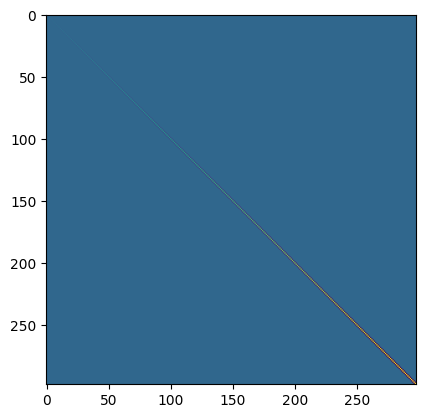

In [ ]:
from numpy import array
from numpy.linalg import eig
from matplotlib.pyplot import imshow
from typing import Callable                 # I love typed python sue me! (It makes me feel safe)

# Define the differential operator matrix
# This is simply plugging in the formula we derived above
def get_D(p:Callable, q:float, N:int):
    L       = range(1,N)
    h       = 1/(2*(N))
    delta   = lambda n,m: 1 if n == m else 0
    D       = lambda n,m: ((N)**2 * (p(2*h*n + h) + p(2*h*n - h)) + q) * delta(n,m) \
                        -  (N)**2 *  p(2*h*n + h) * delta(n+1,m) \
                        -  (N)**2 *  p(2*h*n - h) * delta(n-1,m)
    return array([[ D(n,m) for m in L] for n in L])

# Let's get one for the initial condition too
def get_init(N:int):
    u = lambda x: x if 0<x<0.5 else -x + 1 if 0.5<= x < 1 else 0
    L = range(1,N)
    return array([u(n/N) for n in L])

# We can get some constants
# We have already nondimensionalized, but we also don't really need to redcale at this range
N   = 299                               # Some points
rho = 5                                 # kg/m s^2
q   = 20/rho                            # This is unitless
p   = lambda x: (x) * 2/rho             # So is that - x**3
D   = get_D(p,q,N)                      # The actual matrix
u0  = get_init(N)                       # The initial condition
    
# Look! D is tridiagonal
imshow(D);

In [8]:
from numpy import argsort, linspace
from numpy.linalg import inv

# Let's actually calculate the eigenvectors
eigenvalues, eigenvectors = eig(D)

# Let's sort them realquick
idx             = argsort(eigenvalues)
eigenvalues     = eigenvalues[idx]
eigenvectors    = eigenvectors.T[idx].T
W               = {value:vector for value, vector in zip(eigenvalues,eigenvectors.T)}

# We can also calculate the coefficients a_k like so 
a = inv(eigenvectors).dot(u0)

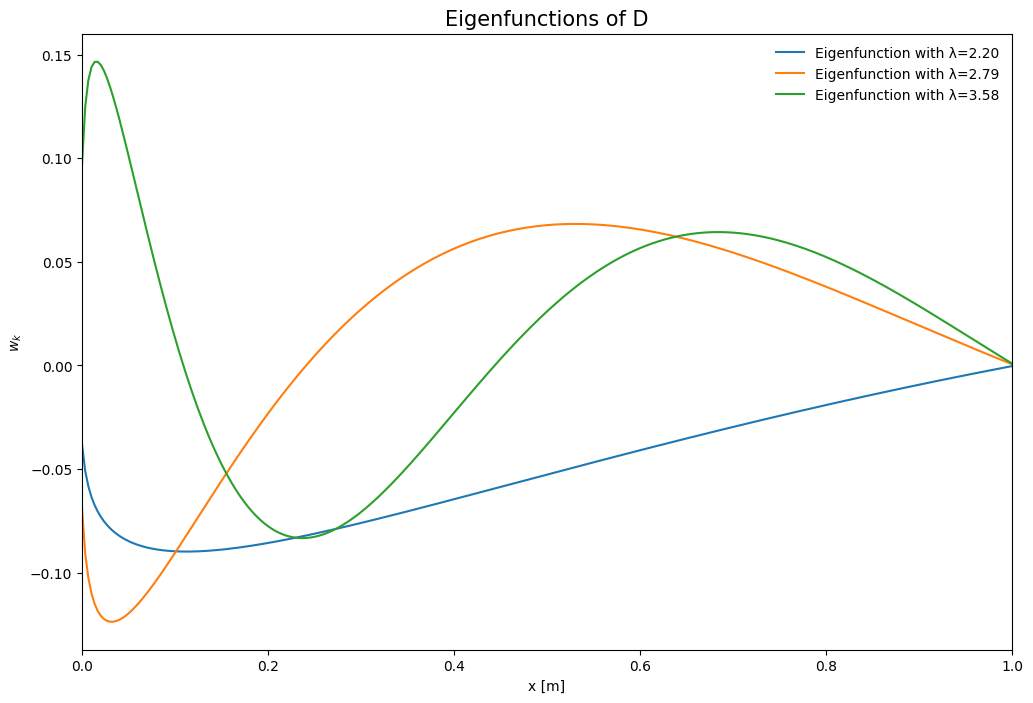

In [9]:
import matplotlib.pyplot as plt

# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)
x   = linspace(1/N,N-1/N,N-1)/(N)

# Add the plot elements
for value in W:
    if value < 15:
        ax.plot(x, W[value], label="Eigenfunction with " + (f"λ={value**0.5:.2f}" if value > 0 else f"λ={(-value)**0.5:.2f}i") )

# Some prettification steps
ax.set_title(r"Eigenfunctions of D",fontsize=15)
ax.set_ylabel(r'$w_k$')
ax.set_xlabel(r'x [m]')
ax.legend(frameon=False)
ax.set_xlim(0,1);

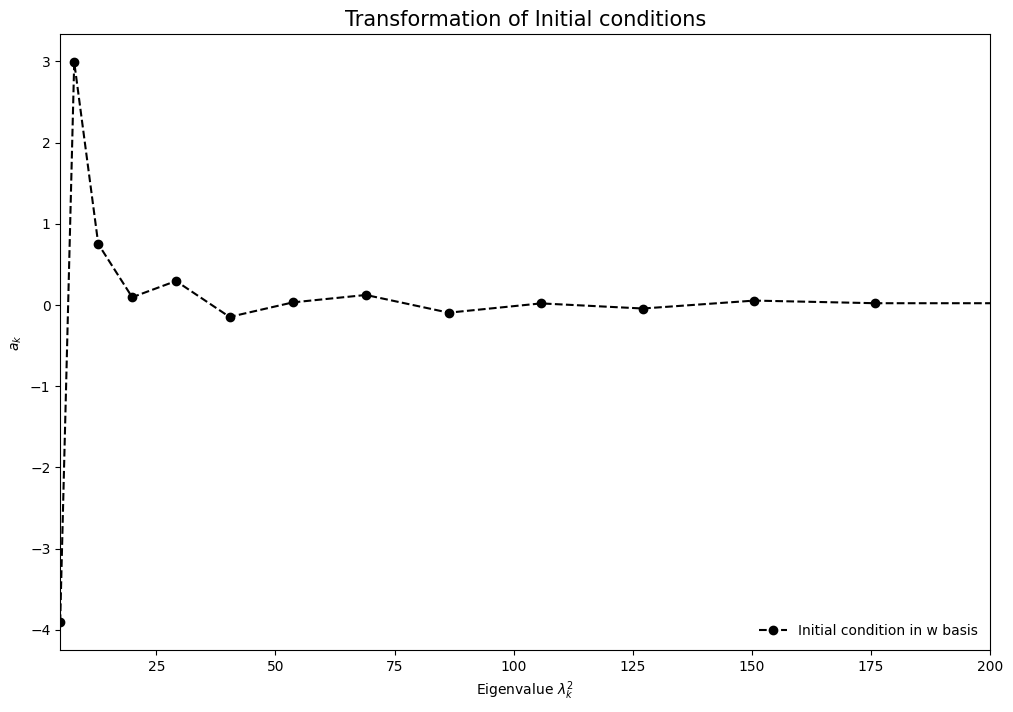

In [10]:
# Let's plot the transform of the initial condition in the new basis
# PLOTTING ---------------------------------------------------
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)
x   = linspace(1,N-1,N-1)

# Add the plot elements
ax.plot(eigenvalues, a, c='k', marker='o', ls='--', label="Initial condition in w basis")

# Some prettification steps
ax.set_title(r"Transformation of Initial conditions",fontsize=15)
ax.set_ylabel(r'$a_k$')
ax.set_xlabel(r'Eigenvalue $\lambda_k^2$')
ax.legend(frameon=False, loc="lower right")
ax.set_xlim(eigenvalues[0],200);

In [11]:
# Finally let's animate!
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from numpy import cos, real

# Let's define a function that shows us how the vector evolves in time
def evolve_to(t:float, a = a, eigenvalues = eigenvalues, eigenvectors = eigenvectors):
    v = real(cos((eigenvalues + 0.j)**0.5 * t))
    return eigenvectors.dot(v*a).flatten()

# ANIMATING ---------------------------------------------------
fig     = plt.figure(figsize=(12,8))
ax      = fig.add_subplot(111)
x       = linspace(1/N,N-1/N,N-1)/(N)
dt      = 0.05
T       = 10
frames  = int(T/dt)

# Add the plot elements
line, = ax.plot(x, evolve_to(0), c='darkblue', label="String at t=0.0")
ax.plot(x,[0]*len(x),c='darkgrey',ls='--')

def init():
    # Some prettification steps
    ax.set_title(r"Let go of a string",fontsize=15)
    ax.set_ylabel(r'height')
    ax.set_xlabel(r'x')
    ax.legend(frameon=False, loc="lower right")
    ax.set_xlim(0,1)
    ax.set_ylim(-0.7,0.7)
    
    return line, 

# What to replot each frame
def frame(i):
    line.set_data(x, evolve_to(i*dt))
    line.set_label(f"String at t={i*dt:4.1f}")
    ax.legend(frameon=False, loc="lower right")
    
    return line, 

animation = FuncAnimation(fig, frame, init_func=init, frames=frames, interval=25, blit=True)
plt.close()

HTML(animation.to_html5_video())

# Problem 2: Root finding for Energy Levels

We want to solve the equation 
$$
\tan z = \sqrt{\frac{z^2_0}{z^2}  - 1}
$$

There are no real solutions ousize $[-z_0,z_0]$ so we will limit our search to that interval search there. One more thing to notice, is that there is a pole at z = 0, so we don't want to keep searching too close to that region. The good thing though is that there will always be a solution in $[0,\pi/2]$, so after we find that, there is no reason to keep searching near $0$. 

Our numerical method will solve the equation $f(x) - \tan(z) = 0$ in intervals $[k\pi/2,(k+1)\pi/2]$ with integer $k$ until $(k+1)\pi/2 > z_0$ or $k\pi/2 < -z_0$.

Let's write that

In [12]:
from numpy import tan
from scipy.optimize import brentq                                   # Root finding lol
from scipy.constants import hbar, electron_volt, milli, m_p, pi     # Constants in SI units

def solve_levels(z0: float):
    # The maximum integer multiple 
    max_k = int(z0/pi) + 1

    # The range of intervals of pi/2 to search for solutions in
    K = list(range(-(max_k-1), max_k))

    # The function to solve for
    f = lambda z: ((z0/z)**2 - 1)**(0.5) - tan(z)
    
    # A little padding so that we don't get hit by the infinities. 
    epsilon = 1e-14

    # By continuity, perioidicity, and monotonicity of the image 
    # there has to be a unique solution in each interval
    return array([brentq(f, max(-z0,(k-0.5)*pi) + epsilon, min(z0,(k+0.5)*pi) - epsilon) for k in K])


# Definition of the initial conditions
a   = 1e-9
V0  = 10*milli*electron_volt
z0  = a*(2*m_p*V0)**0.5 / hbar

# Solve for the roots 
roots = solve_levels(z0)

# Convert to energy levels
levels = roots**2 * (hbar/a)**2 / (2*m_p*milli*electron_volt) - V0/(milli*electron_volt)

print("The energy levels are:")
[print(f"{k+1:2d}: {E:7.4f}") for (k,E) in enumerate(sorted(levels))];


The energy levels are:
 1: -9.9532
 2: -9.9438
 3: -9.5788
 4: -9.4938
 5: -8.8312
 6: -8.5916
 7: -7.7136
 8: -7.2321
 9: -6.2317
10: -5.4044
11: -4.3967
12: -3.0806
13: -2.2371
